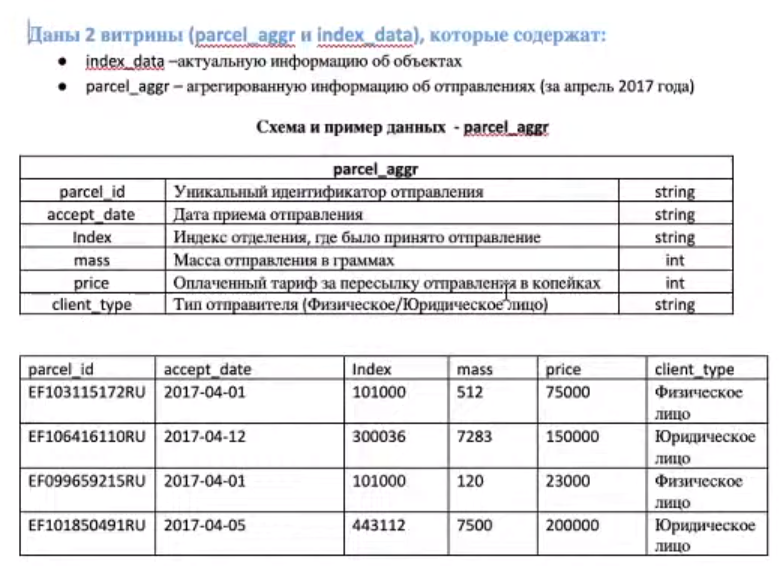

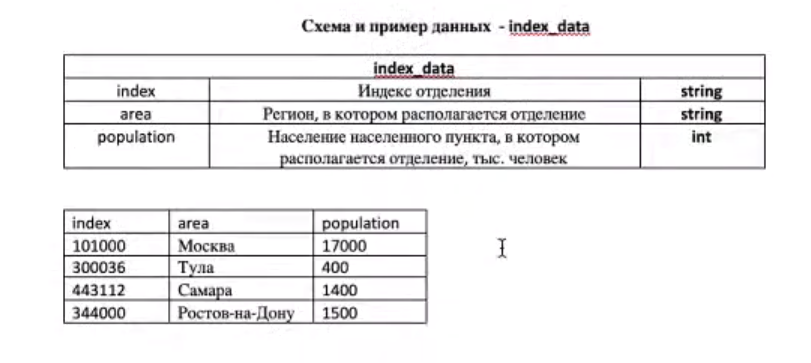

1. Вывести средний размер тарифа на пересылку и массы по индексам отделений, в которых было принято отправление.

2. Вывести количество отправлений в разрезе индексов отделений, в которых было принято отправление. Учитывать только те отправления, у которых масса больше или равна 10 кг.

3. Вывести количество отправлений в разрезе типа отправителя и группы по численности населения населенного пункта, в котором было принято отправление (меньше 50 тыс. (включительно), от 50 до 100 тыс. (включительно), от 100 до 500 тыс. (включительно), больше 500 тыс.).

4. Вывести идентификатор отправления; регион, где было принято отправление; численность населения населенного пункта, в котором было принято отправление и стоимость пересылки отправления (в рублях) с максимальной массой в каждом филиале.

5. Вывести идентификаторы отправлений, у которых масса строго больше, чем в среднем по базе.

6. Перед отпуском руководитель попросил вас: «вывести распределение количества отправлений по стоимости пересылки*». Необходимо подготовить 1 слайд, который раскроет данную проблематику.

## Сгенерируем данные и подключим библиотеки

In [1]:
import sqlite3

In [38]:
import pandas as pd
import numpy as np
from scipy. stats import lognorm
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm

In [18]:
parcel_aggr = pd.DataFrame({'parcel_id':range(100)})

In [19]:
parcel_aggr['accept_date'] = (pd.Series(pd.date_range(start='2017-04-01',end='2017-04-30'))
.sample(100,replace=True,random_state=42).values)

In [139]:
parcel_aggr['index_i'] = pd.Series(range(10)).sample(100,replace=True,random_state=42).values

In [178]:
parcel_aggr = parcel_aggr.drop(['index'], axis=1)

In [161]:
np.random.seed(42)
parcel_aggr['mass'] =pd.Series(np.floor([np.random.lognormal(mean=5, sigma=2, size=(10000,)).mean() for _ in tqdm(range(1000))])).astype(int)
parcel_aggr['price'] = np.round(np.abs(np.random.normal(10000,40000,size=100))).astype(int)
parcel_aggr['client_type'] = (pd.Series(['Физическое лицо','Юридическое лицо']).sample(100,replace=True,random_state=42).values)

<AxesSubplot:>

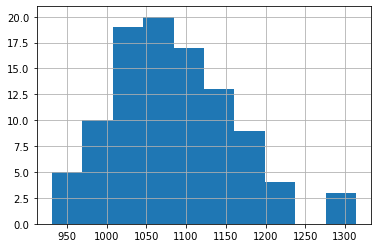

In [162]:
parcel_aggr['mass'].hist()

In [179]:
parcel_aggr

,parcel_id,accept_date,mass,price,client_type,index_i
0,0,2017-04-07,1118,49282,Физическое лицо,6
1,1,2017-04-20,1210,18160,Юридическое лицо,3
2,2,2017-04-29,997,9389,Физическое лицо,7
3,3,2017-04-15,1066,26498,Физическое лицо,4
4,4,2017-04-11,1010,112618,Физическое лицо,6
...,...,...,...,...,...,...
95,95,2017-04-29,983,4577,Юридическое лицо,9
96,96,2017-04-18,1168,35376,Юридическое лицо,8
97,97,2017-04-26,1050,40755,Юридическое лицо,6
98,98,2017-04-12,1006,34998,Юридическое лицо,8


In [180]:
parcel_aggr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   parcel_id    100 non-null    int64         
 1   accept_date  100 non-null    datetime64[ns]
 2   mass         100 non-null    int32         
 3   price        100 non-null    int32         
 4   client_type  100 non-null    object        
 5   index_i      100 non-null    int64         
dtypes: datetime64[ns](1), int32(2), int64(2), object(1)
memory usage: 4.0+ KB


In [181]:
parcel_aggr['index_i'].value_counts()

7    15
8    12
9    11
6    11
4    10
1    10
3     9
2     9
0     7
5     6
Name: index_i, dtype: int64

In [166]:
parcel_aggr['index_i'].unique()

array([6, 3, 7, 4, 9, 2, 5, 1, 0, 8], dtype=int64)

In [182]:
np.random.seed(42)
index_data = pd.DataFrame({'index_id':range(10)})
index_data['area'] = ['a','b','c','d','e','f','g','h','i','j']
index_data['population'] = np.round(np.abs(np.random.normal(10000,40000,size=10))).astype(int)

In [183]:
index_data

,index_id,area,population
0,0,a,29869
1,1,b,4469
2,2,c,35908
3,3,d,70921
4,4,e,634
5,5,f,635
6,6,g,73169
7,7,h,40697
8,8,i,8779
9,9,j,31702


In [184]:
con = sqlite3.connect('db')
cur = con.cursor()

In [185]:
parcel_aggr.to_sql('parcel_aggr',con,if_exists='replace',index=False)
index_data.to_sql('index_data',con,if_exists='replace',index=False)

In [186]:
def select(sql):
  return pd.read_sql(sql,con)

In [187]:
parcel_aggr

,parcel_id,accept_date,mass,price,client_type,index_i
0,0,2017-04-07,1118,49282,Физическое лицо,6
1,1,2017-04-20,1210,18160,Юридическое лицо,3
2,2,2017-04-29,997,9389,Физическое лицо,7
3,3,2017-04-15,1066,26498,Физическое лицо,4
4,4,2017-04-11,1010,112618,Физическое лицо,6
...,...,...,...,...,...,...
95,95,2017-04-29,983,4577,Юридическое лицо,9
96,96,2017-04-18,1168,35376,Юридическое лицо,8
97,97,2017-04-26,1050,40755,Юридическое лицо,6
98,98,2017-04-12,1006,34998,Юридическое лицо,8


## Данные

In [188]:
sql = '''select * from parcel_aggr t'''
select(sql)

,parcel_id,accept_date,mass,price,client_type,index_i
0,0,2017-04-07 00:00:00,1118,49282,Физическое лицо,6
1,1,2017-04-20 00:00:00,1210,18160,Юридическое лицо,3
2,2,2017-04-29 00:00:00,997,9389,Физическое лицо,7
3,3,2017-04-15 00:00:00,1066,26498,Физическое лицо,4
4,4,2017-04-11 00:00:00,1010,112618,Физическое лицо,6
...,...,...,...,...,...,...
95,95,2017-04-29 00:00:00,983,4577,Юридическое лицо,9
96,96,2017-04-18 00:00:00,1168,35376,Юридическое лицо,8
97,97,2017-04-26 00:00:00,1050,40755,Юридическое лицо,6
98,98,2017-04-12 00:00:00,1006,34998,Юридическое лицо,8


In [189]:
sql = '''select * from index_data t'''
select(sql)

,index_id,area,population
0,0,a,29869
1,1,b,4469
2,2,c,35908
3,3,d,70921
4,4,e,634
5,5,f,635
6,6,g,73169
7,7,h,40697
8,8,i,8779
9,9,j,31702


## Вывести средний размер тарифа на пересылку и массы по индексам отделений, в которых было принято отправление.

In [192]:
sql = '''select index_i,
    count(index_i) as cnt,
    avg(price) as avg_price,
    avg(mass) as avg_mass
from parcel_aggr
group by index_i'''

In [193]:
select(sql)

,index_i,cnt,avg_price,avg_mass
0,0,7,32639.142857,1098.857143
1,1,10,33840.500000,1076.900000
2,2,9,30962.333333,1085.111111
3,3,9,29818.222222,1082.111111
4,4,10,31804.200000,1103.400000
5,5,6,13973.000000,1091.833333
6,6,11,39604.727273,1047.636364
7,7,15,34900.400000,1069.266667
8,8,12,37262.000000,1079.583333
9,9,11,40433.818182,1111.818182


## Вывести количество отправлений в разрезе индексов отделений, в которых было принято отправление. Учитывать только те отправления, у которых масса больше или равна 10 кг.

In [209]:
sql = '''select index_i,
    count(index_i) as total_count,
    count(case when mass >= 1000 then index_i else null end) as ten_count
from parcel_aggr
group by index_i'''

select(sql)

,index_i,total_count,ten_count
0,0,7,6
1,1,10,10
2,2,9,7
3,3,9,9
4,4,10,10
5,5,6,5
6,6,11,9
7,7,15,12
8,8,12,11
9,9,11,10


## Вывести количество отправлений в разрезе типа отправителя и группы по численности населения населенного пункта, в котором было принято отправление (меньше 50 тыс. (включительно), от 50 до 100 тыс. (включительно), от 100 до 500 тыс. (включительно), больше 500 тыс.)

In [214]:
sql = '''select p.client_type,
    (case when i.population <= 5000 then 'меньше 5 тыс.'
     when i.population <= 10000 then '5-10 тыс.'
     when i.population <= 50000 then '10-50 тыс.'
     else 'больше 50 тыс.' end) as population_group,
    count(p.index_i) as count
    
from parcel_aggr p
left join index_data as i on i.index_id = p.index_i

group by  client_type, 
    (case when i.population <= 5000 then 'меньше 5 тыс.'
     when i.population <= 10000 then '5-10 тыс.'
     when i.population <= 50000 then '10-50 тыс.'
     else 'больше 50 тыс.' end)
     
order by 1,2'''

select(sql)

,client_type,population_group,count
0,Физическое лицо,10-50 тыс.,20
1,Физическое лицо,5-10 тыс.,2
2,Физическое лицо,больше 50 тыс.,10
3,Физическое лицо,меньше 5 тыс.,12
4,Юридическое лицо,10-50 тыс.,22
5,Юридическое лицо,5-10 тыс.,10
6,Юридическое лицо,больше 50 тыс.,10
7,Юридическое лицо,меньше 5 тыс.,14


## Вывести идентификатор отправления; регион, где было принято отправление; численность населения населенного пункта, в котором было принято отправление и стоимость пересылки отправления (в рублях) с максимальной массой в каждом филиале

In [216]:
sql = '''select p.parcel_id,
    i.area,
    i.population,
    p.price,
    max(mass) over(partition by index_i) as max_mass
    
from parcel_aggr p
left join index_data as i on i.index_id = p.index_i

order by 1'''

select(sql)

,parcel_id,area,population,price,max_mass
0,0,g,73169,49282,1130
1,1,d,70921,18160,1210
2,2,h,40697,9389,1172
3,3,e,634,26498,1203
4,4,g,73169,112618,1130
...,...,...,...,...,...
95,95,j,31702,4577,1303
96,96,i,8779,35376,1197
97,97,g,73169,40755,1130
98,98,i,8779,34998,1197


## Вывести идентификаторы отправлений, у которых масса строго больше, чем в среднем по базе.

In [220]:
sql = '''select p.parcel_id
    
from parcel_aggr p
where p.mass > (select avg(mass) from parcel_aggr)

order by 1'''

select(sql)

,parcel_id
0,0
1,1
2,7
3,8
4,9
5,10
6,11
7,13
8,14
9,15


## Перед отпуском руководитель попросил вас: «вывести распределение количества отправлений по стоимости пересылки*». Необходимо подготовить 1 слайд, который раскроет данную проблематику.

In [221]:
parcel_aggr['price'].describe()

count       100.000000
mean      33668.580000
std       25118.569019
min         439.000000
25%       13542.500000
50%       29352.500000
75%       45253.500000
max      121657.000000
Name: price, dtype: float64

<AxesSubplot:>

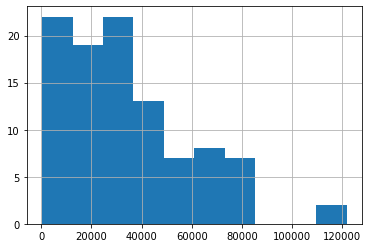

In [222]:
parcel_aggr['price'].hist()

<AxesSubplot:title={'center':'price'}, xlabel='index_i'>

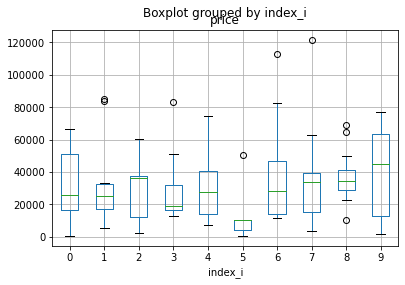

In [226]:
parcel_aggr.boxplot('price',by='index_i')

In [229]:
parcel_aggr.groupby('index_i')['price'].count()

index_i
0     7
1    10
2     9
3     9
4    10
5     6
6    11
7    15
8    12
9    11
Name: price, dtype: int64